# Running Dask on AzureML

This notebook shows how to run a Dask cluster on an AzureML Compute cluster. 
For setup instructions of you python environment, please see the [Readme](../README.md)

## Starting the cluster

In [1]:
from azureml.core import Workspace, Experiment
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from azureml.core.runconfig import MpiConfiguration
from azureml.core import VERSION
import uuid
import time
VERSION

# some helper to generate URLs later
class DaskURLs:
    def __init__(self, bokeh_port, jupyter_port, jupyter_token):
        self.bokeh_port = bokeh_port
        self.jupyter_port = jupyter_port
        self.jupyter_token = jupyter_token
        
    def _repr_javascript_(self):
        return f'''
        var hostname = window.location.hostname
        var dot = hostname.indexOf('.')
        var first = hostname.substr(0, dot)
        var last = hostname.substr(dot)
        var bokeh = 'https://' + first +'-{self.bokeh_port}'+ last
        var jupyter = 'https://' + first +'-{self.jupyter_port}'+ last+'?token={self.jupyter_token}'
        element.html(`
            Bokeh: <a href=`+bokeh+` target='bokeh'>`+bokeh+`</a><br>
            Jupyter: <a href=`+jupyter+` target='jupyter'>`+jupyter+`</a><br>`)
        '''

In [2]:
ws = Workspace.from_config()

# Create AML Compute Cluster 

As you need to connect to compute cluster via Compute Instance, make sure you create __SSH enabled__ AML Compute Cluster. And of course remember the ID and Password forport-forwarding from Notebook VM to Dask Scheduler.


In [3]:
# 'dask-DS2-V22' was created from AML Stduio
# SSH is Enabled
dask_cluster = ws.compute_targets['dask-DS2-V22']

In [4]:
dask_cluster

AmlCompute(workspace=Workspace.create(name='mtcs-dev-azml', subscription_id='256c7222-4083-4ba7-8714-baa0df54bfe6', resource_group='mtcs-dev-azml-rg'), name=dask-DS2-V22, id=/subscriptions/256c7222-4083-4ba7-8714-baa0df54bfe6/resourceGroups/mtcs-dev-azml-rg/providers/Microsoft.MachineLearningServices/workspaces/mtcs-dev-azml/computes/dask-DS2-V22, type=AmlCompute, provisioning_state=Succeeded, location=westus2, tags=None)

Starting the Dask cluster using an Estimator with MpiConfiguration. Make sure the cluster is able to scale up to few nodes.

In [5]:
from azureml.core import Environment

myEnv = Environment.from_conda_specification('startDask', './dask/environment.yml')
myEnv

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210104.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": "2g"
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "startDask",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "defaults",
                "conda-forge"
  

In [6]:
datastore = ws.get_default_datastore()
data_ref = datastore.path('./').as_mount()

In [36]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import MpiConfiguration


src = ScriptRunConfig(source_directory='./dask',
                       script='startDask.py',
                       environment=myEnv,
                       arguments=['--datastore', str(data_ref)],
                       compute_target=dask_cluster,
                       distributed_job_config=MpiConfiguration(node_count=3)
                       )
src.run_config

{
    "script": null,
    "arguments": [],
    "target": "dask-DS2-V22",
    "framework": "Python",
    "communicator": "IntelMpi",
    "maxRunDurationSeconds": 2592000,
    "nodeCount": 3,
    "priority": null,
    "environment": {
        "name": "startDask",
        "version": null,
        "environmentVariables": {
            "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
        },
        "python": {
            "userManagedDependencies": false,
            "interpreterPath": "python",
            "condaDependenciesFile": null,
            "baseCondaEnvironment": null,
            "condaDependencies": {
                "name": "dask",
                "channels": [
                    "defaults",
                    "conda-forge"
                ],
                "dependencies": [
                    "gcsfs",
                    "fs-gcsfs",
                    "jupyterlab",
                    "jupyter-server-proxy",
                    "python=3.6",
                    "numpy",
           

In [37]:
run = Experiment(ws, 'startDask').submit(src)

In [38]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [39]:
from IPython.display import clear_output

print("waiting for scheduler node's ip")
while not 'headnode' in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

clear_output()
headnode_private_ip = run.get_metrics()['headnode']
print('Headnode has IP:', headnode_private_ip)

Headnode has IP: 10.0.0.6


In [40]:
# let's find the public IP and ssh port of the head node

headnode_public_ip = None
headnode_ssh_port = None
for node in dask_cluster.list_nodes():
    if node['privateIpAddress'] == headnode_private_ip:
        headnode_public_ip = node['publicIpAddress']
        headnode_ssh_port = node['port']
        break
        
if headnode_public_ip == None:
    print('Headnode not found in cluster')
else:
    print(f'Headnode is at {headnode_public_ip}:{headnode_ssh_port}')

Headnode is at 20.83.80.165:50002


## Establish the port-forwarding from Notebook VM to Dask Scheduler
Since Notebook VM does not yet support VNets, you need to build an SSH port forwarder through SSH login.

In the prior cell we looked up the public IP and port of the headnode of the cluster 

Now, open the terminal on the Notebook VM and type what the following cell outputs  


In [41]:
print(f'ssh azureuser@{headnode_public_ip} -p {headnode_ssh_port} -L 8786:localhost:8786 -L 8788:{headnode_private_ip}:8787 -L 9999:localhost:8888')

ssh azureuser@20.83.80.165 -p 50002 -L 8786:localhost:8786 -L 8788:10.0.0.6:8787 -L 9999:localhost:8888


Make sure to leave the terminal tab open to keep the port-forward running

As you see, you are forwarding 3 ports 

1. 8786 is for the scheduler and will be used to connect the client to the cluster
2. 8788 is for the Bokeh app that shows the activity on the cluster (we are mapping to the local port 8788 to avoid a conflict with the RStudio Server running on the Notebook VM)
3. 9999 is for a jupyter instance running on the head node. You can connect to the scheduler from the jupyter running on your Notebook VM or from this jupyter instance on the head node.   

To access the Bokeh app, change the URL to your notebook VM by adding `-8788` right after the machine name. If you are running this notebook on a Notebook VM, then you can create the URLs by excuting the next cell:

In [42]:
print("waiting for jupyter token")
while not 'jupyter-token' in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

# this will only work when running on a Notebook VM
DaskURLs('8788', '9999', run.get_metrics()['jupyter-token'])

waiting for jupyter token


Hopefully, you are seeing this after you clicked on the Bokeh link and then select 'Status':

![Bokeh](../img/bokeh.png)

If you are wondering what all this port business in accomplishing, please see the graph below that tries to illustrate who talks to whom and how.

![Network](../img/network.png)

## Run some jobs on the cluster
If you are able to see the Bokeh app, it is time to use the cluster. Thanks to the port forward, the scheduler appears to the notebook VM at `tcp://localhost:8786`. You should see 10 workers.

In [43]:
from dask.distributed import Client

c = Client('tcp://localhost:8786')
c.restart()
c

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/distributed/client.py:1135: VersionMismatchWarning: Mismatched versions found

+---------+---------------+----------------+----------------+
| Package | client        | scheduler      | workers        |
+---------+---------------+----------------+----------------+
| lz4     | 3.1.3         | None           | None           |
| python  | 3.6.9.final.0 | 3.6.10.final.0 | 3.6.10.final.0 |
+---------+---------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 3 Cores: 6 Memory: 20.82 GB


See if the cluster works

In [44]:
import time
import numpy as np
from dask import delayed, visualize

def inc(x):
    time.sleep(abs(np.random.normal(5, 2)))
    return x + 1

fut = []
for i in range(10):
    fut.append( c.submit(delayed(inc), i) )

fut

[<Future: pending, key: Delayed('inc-b806b01e-e648-481b-98cb-4a5ad5a60c90'-f46abc6a72700febf3254192004b3bec>,
 <Future: pending, key: Delayed('inc-ca974aea-e470-498c-867a-ab9bf0cc35ff'-a4e408b1ddb37710e221f05c951fba90>,
 <Future: pending, key: Delayed('inc-d0f4ee9d-1757-4241-bf40-2bc167345664'-dda60f7b2c5b9e23a00a1f9a8ad821fe>,
 <Future: pending, key: Delayed('inc-3b83f333-b219-41b8-8dd5-bf9654091f30'-9ebfe07d20033a1a13d8835bcf2e16fe>,
 <Future: pending, key: Delayed('inc-011c7965-12ee-42db-8709-fd02b51af172'-0770060921970fb47263f9f45112d927>,
 <Future: pending, key: Delayed('inc-1f5e8e91-fa0f-49f9-acea-8b846586126e'-50ef6ec90f3f2925beabe8f2b144e13c>,
 <Future: pending, key: Delayed('inc-d8aaf702-2830-4137-a46e-60a825d41b36'-951ccf650ee919bcac76b946fb3ad936>,
 <Future: pending, key: Delayed('inc-2357645b-c186-4760-be0c-fb055000d05f'-07b2ac2f0a0f0385288bc687be44cc46>,
 <Future: pending, key: Delayed('inc-02b78571-d626-44e4-8c3d-8993956b57de'-f844033bab35ca500de334245ab6d91f>,
 <Future: 

In [45]:
for i in fut:
    print(i.result())

Delayed('inc-afdd6b30-808a-4d53-8843-a4400d94e8a9')
Delayed('inc-d19fe791-53f9-4b13-ad47-7b1b4252578c')
Delayed('inc-63ab8653-ed9b-4aaa-8baf-b17fc250aead')
Delayed('inc-11877d0b-680d-4e9d-a879-dc6f292823d8')
Delayed('inc-f7536cc0-32cc-40d3-9238-9c22358a188d')
Delayed('inc-b6f48676-4e29-4f9a-9f12-db235d810924')
Delayed('inc-d5c30ec9-b196-4ead-ae85-485de0cf5de7')
Delayed('inc-d9a5e0e0-9845-49dc-b338-19e4e9a1bc8c')
Delayed('inc-0cef8a93-8783-4511-a96b-134c307e3648')
Delayed('inc-e0b476b8-80f1-4b3a-a225-c73932fbbbb9')


In [46]:
def sum(a):
    x = 0
    for y in a:
        x += y
    return x

results = []
for f in fut:
    results.append(f.result())
    
fut2 = c.submit(sum, results)
fut2

<Future: pending, key: sum-9bc86b82686543e1c6fd64e664b26051>

In [47]:
fut2.result().compute()

55

use terminal to install graphviz 
```bash
sudo apt-get install graphviz
```

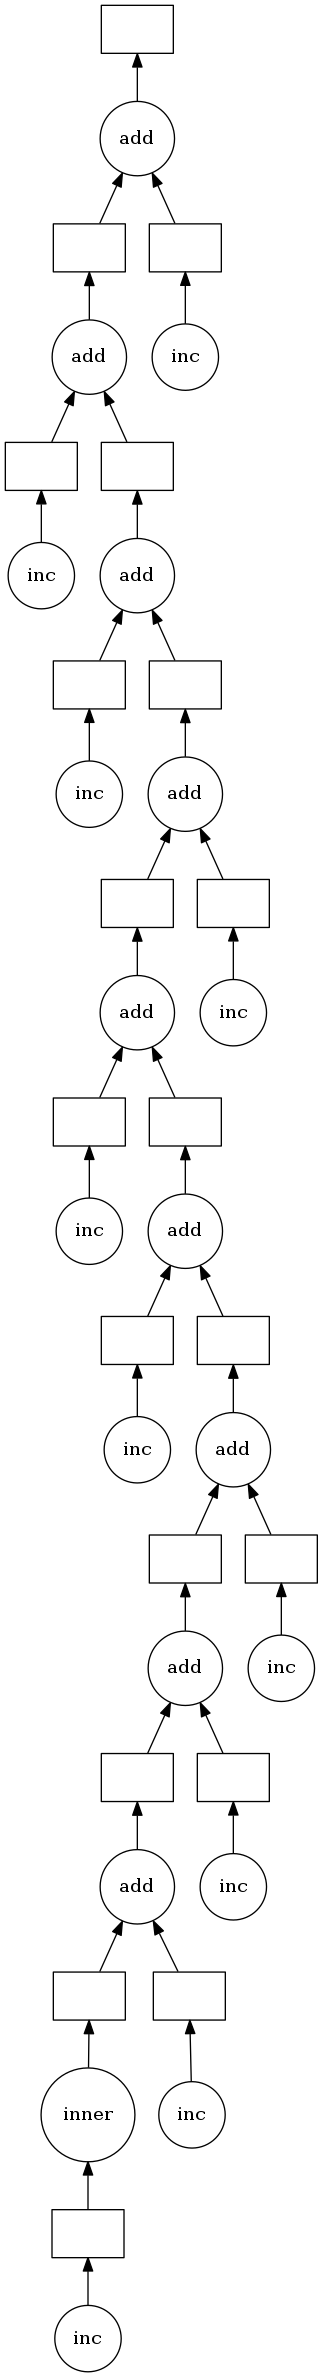

In [48]:
visualize(fut2.result())

# Training on Large Datasets
(from https://github.com/dask/dask-tutorial)

Sometimes you'll want to train on a larger than memory dataset. `dask-ml` has implemented estimators that work well on dask arrays and dataframes that may be larger than your machine's RAM.

In [49]:
from dask.distributed import Client
import joblib
import dask.array as da
import dask.delayed
from sklearn.datasets import make_blobs
import numpy as np

We'll make a small (random) dataset locally using scikit-learn.

In [50]:
n_centers = 12
n_features = 20

X_small, y_small = make_blobs(n_samples=1000, centers=n_centers, n_features=n_features, random_state=0)

centers = np.zeros((n_centers, n_features))

for i in range(n_centers):
    centers[i] = X_small[y_small == i].mean(0)
    
centers[:4]

array([[ 1.00796679,  4.34582168,  2.15175661,  1.04337835, -1.82115164,
         2.81149666, -1.18757701,  7.74628882,  9.36761449, -2.20570731,
         5.71142324,  0.41084221,  1.34168817,  8.4568751 , -8.59042755,
        -8.35194302, -9.55383028,  6.68605157,  5.34481483,  7.35044606],
       [ 9.49283024,  6.1422784 , -0.97484846,  5.8604399 , -7.61126963,
         2.86555735, -7.25390288,  8.89609285,  0.33510318, -1.79181328,
        -4.66192239,  5.43323887, -0.86162507,  1.3705568 , -9.7904172 ,
         2.3613231 ,  2.20516237,  2.20604823,  8.76464833,  3.47795068],
       [-2.67206588, -1.30103177,  3.98418492, -8.88040428,  3.27735964,
         3.51616445, -5.81395151, -7.42287114, -3.73476887, -2.89520363,
         1.49435043, -1.35811028,  9.91250767, -7.86133474, -5.78975793,
        -6.54897163,  3.08083281, -5.18975209, -0.85563107, -5.06615534],
       [-6.85980599, -7.87144648,  3.33572279, -7.00394241, -5.97224874,
        -2.55638942,  6.36329802, -7.97988653,  

The small dataset will be the template for our large random dataset.
We'll use `dask.delayed` to adapt `sklearn.datasets.make_blobs`, so that the actual dataset is being generated on our workers. 

In [51]:
n_samples_per_block = 100000
n_blocks = 500

delayeds = [dask.delayed(make_blobs)(n_samples=n_samples_per_block,
                                     centers=centers,
                                     n_features=n_features,
                                     random_state=i)[0]
            for i in range(n_blocks)]
arrays = [da.from_delayed(obj, shape=(n_samples_per_block, n_features), dtype='float64')
          for obj in delayeds]
X = da.concatenate(arrays)
X

dask.array<concatenate, shape=(100000000, 20), dtype=float64, chunksize=(200000, 20), chunktype=numpy.ndarray>

In [52]:
# Check the size of the array GB
X.nbytes / 1e9

16.0

In [53]:
# Only run this on the cluster.
X = X.persist()  

The algorithms implemented in Dask-ML are scalable. They handle larger-than-memory datasets just fine.

They follow the scikit-learn API, so if you're familiar with scikit-learn, you'll feel at home with Dask-ML.

Install Dask-ML before you run following codes

```bash
conda install -c conda-forge dask-ml
```

In [54]:
from dask_ml.cluster import KMeans
clf = KMeans(init_max_iter=3, oversampling_factor=10)

In [55]:
%time clf.fit(X)

CPU times: user 1min 1s, sys: 4.07 s, total: 1min 6s
Wall time: 33min 49s


KMeans(init_max_iter=3, oversampling_factor=10)

In [56]:
clf.labels_

dask.array<astype, shape=(100000000,), dtype=int32, chunksize=(200000,), chunktype=numpy.ndarray>

In [57]:
clf.labels_[:10].compute()

array([1, 4, 1, 6, 6, 6, 3, 4, 7, 5], dtype=int32)

## Shut cluster down
To shut the cluster down, cancel the job that runs the cluster. 

In [32]:
for run in ws.experiments['startDask'].get_runs():
    if run.get_status() == "Running":
        print(f'cancelling run {run.id}')
        run.cancel()

cancelling run startDask_1614838848_23ec1525


### Just for convenience, get the latest running Run

In [ ]:
for run in ws.experiments['startDask'].get_runs():
    if run.get_status() == "Running":
        print(f'latest running run is {run.id}')
        break